Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


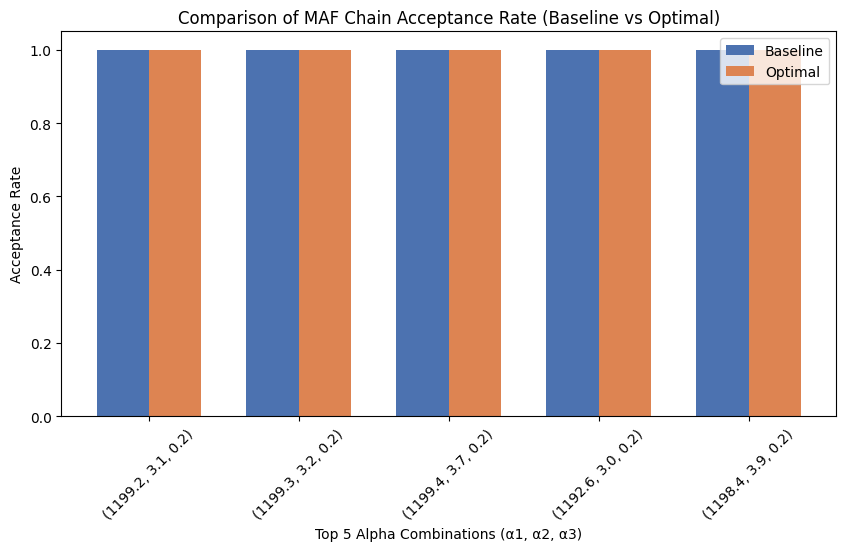

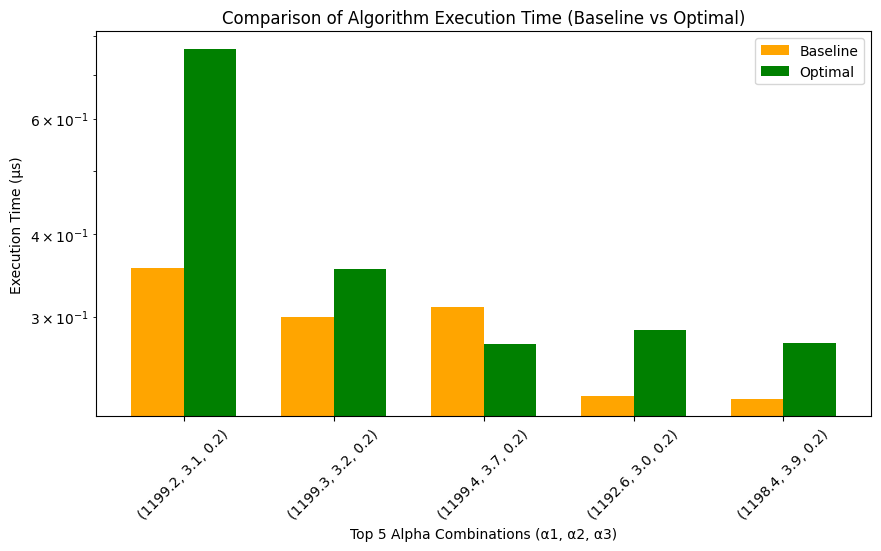

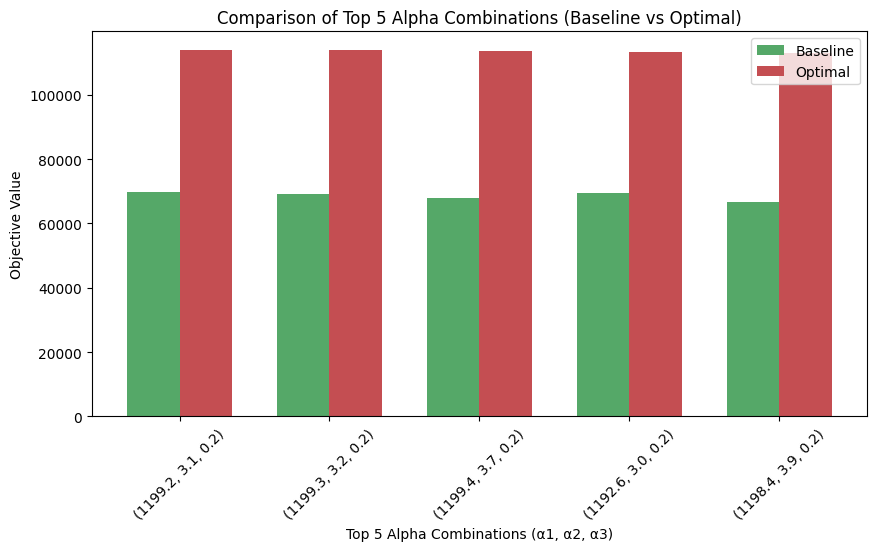

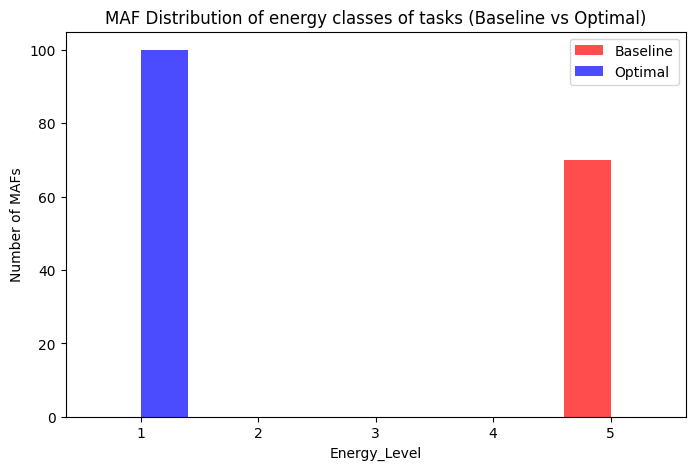

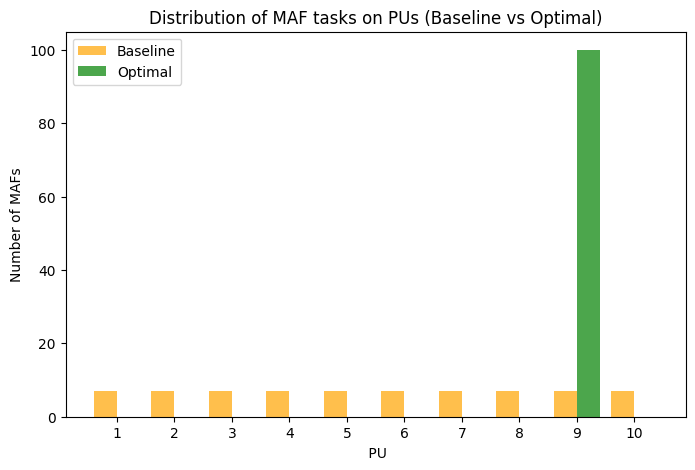

,Alpha Combination,Execution Time (Baseline) (µs),Execution Time (Optimal) (µs)
0,"(1199.2, 3.1, 0.2)",0.356,0.766
1,"(1199.3, 3.2, 0.2)",0.300,0.354
2,"(1199.4, 3.7, 0.2)",0.310,0.273
3,"(1192.6, 3.0, 0.2)",0.227,0.286
4,"(1198.4, 3.9, 0.2)",0.225,0.274


,Alpha Combination,Objective Value (Optimal),Objective Value (Baseline),Improvement (%)
0,"(1199.2, 3.1, 0.2)",114048.444587,69798.403839,63.396924
1,"(1199.3, 3.2, 0.2)",113822.762334,69244.700746,64.377579
2,"(1199.4, 3.7, 0.2)",113619.839834,67840.678847,67.480399
3,"(1192.6, 3.0, 0.2)",113232.088719,69349.344604,63.277807
4,"(1198.4, 3.9, 0.2)",113001.284963,66744.530795,69.304187


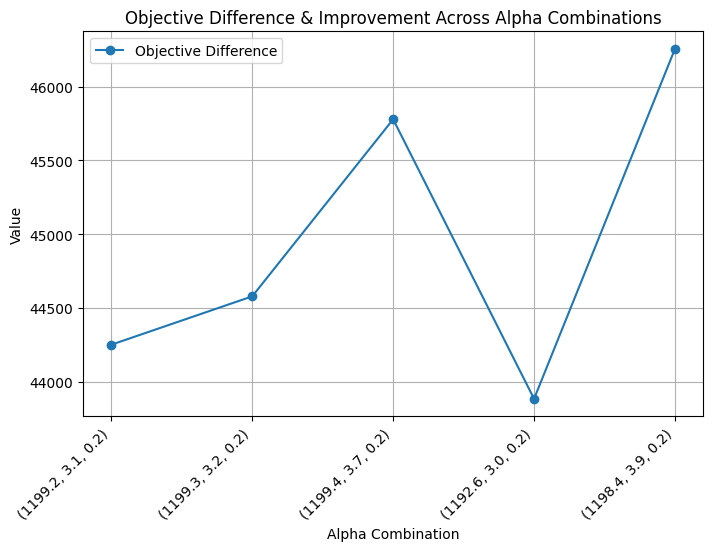

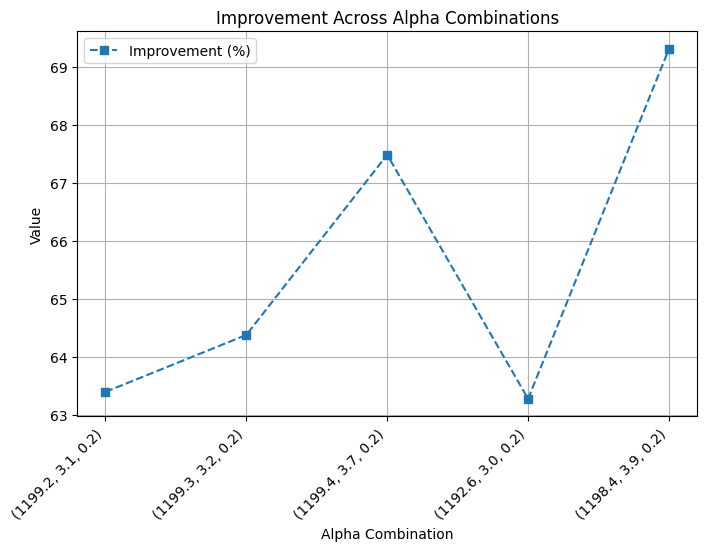

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time 
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import pandas as pd
from IPython.display import display
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]     # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [500] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [5] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
max_latency = 800 


# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}

# Store results
results = []

# === Configure Gurobi Parameters ===
def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

# === Unified Function for Optimal and Baseline Model ===
def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")  # Whether the maf is activated or not
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")  # Which PU the maf is run in
    t = model.addVars(n, vtype=GRB.CONTINUOUS, name="t")  # MAF start time
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  # MAF chain activation
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")  # Energy level for maf selection
    # Fixed PU Idle Energy
    E_idle_fixed = sum(P_idle) * T_total  

    # === MAF Execution Sequence Constraints ===
    for k in range(num_chains):
        chain = chain_tasks[k]
        for i in range(len(chain) - 1):
            model.addConstr(
                t[chain[i]] + quicksum(y[chain[i], e] * L_levels[e] for e in range(K)) <= t[chain[i + 1]],
                name=f"TaskExecution_{chain[i]}"
            )

    # === MAF chain activation constraints ===
    for k in range(num_chains):
        model.addConstr(z_chain_k[k] == gp.max_([delta[i] for i in chain_tasks[k]]), name=f"ChainActivation_{k}")

    # === MAF allocation constraints ===
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i], name=f"TaskAlloc_{i}")  # MAFs must be assigned to a PU
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"EnergyLevelChoice_{i}")  # MAFs must select an energy level

    # === Limit CPU resources per PU ===
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j],
            name=f"OptimalPU_CPU_Limit_{j}"
        )

    # === Limit CPU resources for the entire system ===
    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max,
        name="OptimalTotalSystemResource"
    )

    # === Optimal only: Avoid choosing the lowest energy consumption for all MAFs ===
    if not baseline:
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"EnergyChoice_{i}")
    else:
        model.addConstr(y[i, K-1] == delta[i], name=f"BaselineMaxEnergy_{i}")


    # === Baseline constraints (maximum energy consumption, CPU resource limit) ===
    if baseline:
        # Force all tasks to select the highest energy level
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

        # Directly reuse the CPU constraints of Optimal logic, but fix the K-1 level.
        model.addConstr(
            quicksum(w[i, j] * f_v_levels[K-1] for i in range(n) for j in range(m)) <= C_total_max,
            name="BaselineTotalSystemResource"
        )

        model.addConstrs(
            (quicksum(w[i, j] * f_v_levels[K-1] for i in range(n)) <= CPU_capacity[j] for j in range(m)),
            name="BaselineCPU"
        )

    E_idle = sum(P_idle[j] * (T_total - quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))) for j in range(m))

    # === objective function ===
    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))  # Maximize MAF activation
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))  # Minimization of task energy consumption
        - alpha_3 * E_idle  # PU Idle Energy
    )
    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model
    else:
        return None




# === Run Optimization ===
search_space = [
    Real(1000, 1200, name="alpha_1"),
    Real(3, 6, name="alpha_2"),
    Real(0.2, 3, name="alpha_3")
]

@use_named_args(search_space)
def objective(alpha_1, alpha_2, alpha_3):
    model = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False)
    
    # If the optimization fails, return negative infinity
    if model is None:
        results.append((alpha_1, alpha_2, alpha_3, float('-inf'), None))
        return float('-inf')

    # Getting the target value
    obj_val = model.objVal
    results.append((alpha_1, alpha_2, alpha_3, obj_val, model))  # Storing the complete model
    return -obj_val  # Since skopt is minimized, negative values are returned here.

# Find optimal alpha values
res = gp_minimize(objective, search_space, n_calls=20, n_random_starts=5, random_state=42)

# Selecting the Optimal Alpha Combination
sorted_results = sorted(results, key=lambda x: x[3], reverse=True)[1:6]  # 前5个最优解

# Extract Alpha Portfolio, Target, Model
alpha_labels = [f"({row[0]:.1f}, {row[1]:.1f}, {row[2]:.1f})" for row in sorted_results]
optimal_values = [row[3] for row in sorted_results]
optimal_models = [row[4] for row in sorted_results]

# Running the baseline 
baseline_values = []
baseline_models = []
for row in sorted_results:
    alpha_1, alpha_2, alpha_3 = row[:3]
    baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=True)
    baseline_models.append(baseline_model)
    baseline_values.append(baseline_model.objVal if baseline_model else float('-inf'))

# === Calculation of admittance ratios and execution times ===
acceptance_rates_opt = []
acceptance_rates_base = []
execution_times_opt = []
execution_times_base = []


for i, row in enumerate(sorted_results):
    alpha_1, alpha_2, alpha_3 = row[:3]

    # Operational Optimization Model
    start_time = time.perf_counter()
    optimal_model = optimal_models[i]
    execution_times_opt.append(time.perf_counter() - start_time)  

    # MAF Task Chain for Calculating Acceptance Optimal
    accepted_opt = sum(1 for k in range(num_chains) if optimal_model.objVal > float('-inf'))
    acceptance_rates_opt.append(accepted_opt / num_chains)

    # Run the baseline model
    start_time = time.perf_counter()
    baseline_model = baseline_models[i]
    execution_times_base.append(time.perf_counter() - start_time) 

    # MAF Task Chain for Calculating Acceptance baseline
    accepted_base = sum(1 for k in range(num_chains) if baseline_model.objVal > float('-inf'))
    acceptance_rates_base.append(accepted_base / num_chains)





colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B2"]


# === Visualization of the acceptance ratio  ===
fig, ax1 = plt.subplots(figsize=(10, 5))
x = np.arange(len(alpha_labels))
width = 0.35

ax1.bar(x - width/2, acceptance_rates_base, width, label="Baseline", color="#4C72B0")
ax1.bar(x + width/2, acceptance_rates_opt, width, label="Optimal", color="#DD8452")

ax1.set_xlabel("Top 5 Alpha Combinations (α1, α2, α3)")
ax1.set_ylabel("Acceptance Rate")
ax1.set_title("Comparison of MAF Chain Acceptance Rate (Baseline vs Optimal)")
ax1.set_xticks(x)
ax1.set_xticklabels(alpha_labels, rotation=45)
ax1.legend()

plt.show()

# === Visualize algorithm execution time===
# Find the best unit
max_time = max(max(execution_times_base), max(execution_times_opt))

if max_time > 1:  # If execution time is greater than 1 second, use seconds
    time_unit = "s"
    conversion_factor = 1
elif max_time > 1e-3:  # If greater than 1 ms, use milliseconds
    time_unit = "ms"
    conversion_factor = 1e3
else:  # Default to microseconds
    time_unit = "µs"
    conversion_factor = 1e6

# Convert execution times to the selected unit
execution_times_base_scaled = [t * conversion_factor for t in execution_times_base]
execution_times_opt_scaled = [t * conversion_factor for t in execution_times_opt]

# Plot execution time comparison
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.bar(x - width/2, execution_times_base_scaled, width, label="Baseline", color="orange")
ax2.bar(x + width/2, execution_times_opt_scaled, width, label="Optimal", color="green")

ax2.set_xlabel("Top 5 Alpha Combinations (α1, α2, α3)")
ax2.set_ylabel(f"Execution Time ({time_unit})")  # Dynamically set the unit
ax2.set_title("Comparison of Algorithm Execution Time (Baseline vs Optimal)")
ax2.set_xticks(x)
ax2.set_xticklabels(alpha_labels, rotation=45)

ax2.set_yscale("log")  # Log scale for better visibility
ax2.legend()

plt.show()



# === Comparison of target values ===
fig, ax3 = plt.subplots(figsize=(10, 5))
ax3.bar(x - width/2, baseline_values, width, label="Baseline", color="#55A868")
ax3.bar(x + width/2, optimal_values, width, label="Optimal", color="#C44E52")

ax3.set_xlabel("Top 5 Alpha Combinations (α1, α2, α3)")
ax3.set_ylabel("Objective Value")
ax3.set_title("Comparison of Top 5 Alpha Combinations (Baseline vs Optimal)")
ax3.set_xticks(x)
ax3.set_xticklabels(alpha_labels, rotation=45)
ax3.legend()

plt.show()

# === Operationally optimal optimization solutions  ===
best_alpha = sorted_results[0][:3]

# Obtaining Gurobi models for optimal and baseline scenarios
optimal_model = run_gurobi_model(*best_alpha, baseline=False)
baseline_model = run_gurobi_model(*best_alpha, baseline=True)

# Extracting Energy Rating and PU Allocation Information for MAF Tasks
def extract_results(model):
   
    if model is None:
        return None, None

    maf_energy_levels = np.zeros(n, dtype=int)
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1  

    maf_pu_assignments = np.zeros(n, dtype=int)
    for i in range(n):
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1  

    return maf_energy_levels, maf_pu_assignments

# Extract optimal and baseline tasking results
optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

#  Plotting Comparison of Energy Class Distribution for MAF Tasks
plt.figure(figsize=(8, 5))
plt.hist([baseline_energy_levels, optimal_energy_levels], bins=np.arange(1, K + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["red", "blue"], alpha=0.7)
plt.xlabel("Energy_Level")
plt.ylabel("Number of MAFs")
plt.title("MAF Distribution of energy classes of tasks (Baseline vs Optimal)")
plt.xticks(range(1, K + 1))
plt.legend()
plt.show()

# Plotting MAF task assignment on PUs v
plt.figure(figsize=(8, 5))
plt.hist([baseline_pu_assignments, optimal_pu_assignments], bins=np.arange(1, m + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["orange", "green"], alpha=0.7)
plt.xlabel(" PU")
plt.ylabel("Number of MAFs")
plt.title("Distribution of MAF tasks on PUs (Baseline vs Optimal)")
plt.xticks(range(1, m + 1))
plt.legend()
plt.show()



# Creating a DataFrame to store execution time
df_execution_times = pd.DataFrame({
    "Alpha Combination": alpha_labels,
    "Execution Time (Baseline) (µs)": [t * 1e6 for t in execution_times_base],  # s → us
    "Execution Time (Optimal) (µs)": [t * 1e6 for t in execution_times_opt]  # s → us
})



# Calculation of optimization improvement rate (percentage)
df_improvements = pd.DataFrame({
    "Alpha Combination": alpha_labels,
    "Objective Value (Optimal)": optimal_values,
    "Objective Value (Baseline)": baseline_values,
    "Improvement (%)": [(opt - base) / base * 100 for opt, base in zip(optimal_values, baseline_values)]
})

# Show execution time

display(df_execution_times)

# Table showing improvements
display(df_improvements)




df_improvements["Difference"] = df_improvements["Objective Value (Optimal)"] - df_improvements["Objective Value (Baseline)"]
df_improvements["Improvement (%)"] = (df_improvements["Difference"] / df_improvements["Objective Value (Baseline)"]) * 100


plt.figure(figsize=(8, 5))

plt.plot(df_improvements["Alpha Combination"], df_improvements["Difference"], marker='o', label="Objective Difference")

plt.xlabel("Alpha Combination")
plt.ylabel("Value")
plt.title("Objective Difference & Improvement Across Alpha Combinations")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)

plt.show()




plt.figure(figsize=(8, 5))
plt.plot(df_improvements["Alpha Combination"], df_improvements["Improvement (%)"], marker='s', linestyle='dashed', label="Improvement (%)")
plt.xlabel("Alpha Combination")
plt.ylabel("Value")
plt.title("Improvement Across Alpha Combinations")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.show()


# **Optimization Model for MAF Allocation**

## **Decision Variables**
- **MAF activation (binary variable):**
  $$
  \delta_i \in \{0,1\}, \quad \forall i \in \{1, \dots, n\}
  $$
  where \( \delta_i = 1 \) indicates that task \( i \) is active.

- **MAF-to-PU assignment (binary variable):**
  $$
  w_{i,j} \in \{0,1\}, \quad \forall i \in \{1, \dots, n\}, \forall j \in \{1, \dots, m\}
  $$
  where \( w_{i,j} = 1 \) means that task \( i \) is assigned to processing unit \( j \).

- **MAF start time (continuous variable):**
  $$
  t_i \geq 0, \quad \forall i \in \{1, \dots, n\}
  $$

- **MAF chain activation (binary variable):**
  $$
  z_{\text{chain},k} \in \{0,1\}, \quad \forall k \in \{1, \dots, \text{num\_chains}\}
  $$
  where \( z_{\text{chain},k} = 1 \) indicates that chain \( k \) is active.

- **Energy level selection for each task (binary variable):**
  $$
  y_{i,k} \in \{0,1\}, \quad \forall i \in \{1, \dots, n\}, \forall k \in \{1, \dots, K\}
  $$
  where \( y_{i,k} = 1 \) means that task \( i \) selects energy level \( k \).

---

## **Objective Function**
The objective is to maximize the number of active MAFs while minimizing the total task energy consumption and PU idle energy consumption:
  $$
  \max F = \alpha_1 \sum_{i=1}^n \delta_i - \alpha_2 \sum_{i=1}^n \sum_{k=1}^{K} y_{i,k} E_k - \alpha_3 \sum_{j=1}^{m} P_{\text{idle},j} \cdot \left( T_{\text{total}} - \sum_{i=1}^{n} w_{i,j} \sum_{k=1}^{K} y_{i,k} L_k \right)
  $$
where:
- \( \alpha_1 \) maximizes the number of active tasks.
- \( \alpha_2 \) minimizes total task energy consumption.
- \( \alpha_3 \) minimizes PU idle energy consumption.

---

## **Constraints**
### **(1) MAF execution order within a chain**
  $$
  t_{i} + \sum_{k=1}^{K} y_{i,k} L_k \leq t_{i+1}, \quad \forall i \in \text{chain}
  $$
This ensures that tasks within the same chain execute sequentially.

### **(2) MAF chain activation**
  $$
  z_{\text{chain},k} = \max (\delta_i), \quad \forall i \in \text{chain}_k
  $$
A MAF chain is activated if at least one of its tasks is active.

### **(3) MAF must be assigned to exactly one PU**
  $$
  \sum_{j=1}^{m} w_{i,j} = \delta_i, \quad \forall i
  $$
Ensures that each task is assigned to one processing unit if it is active.

### **(4) MAF must select exactly one energy level**
  $$
  \sum_{k=1}^{K} y_{i,k} = \delta_i, \quad \forall i
  $$
Ensures that each task selects exactly one energy level.

### **(5) PU capacity constraint**
  $$
  \sum_{i=1}^{n} \sum_{k=1}^{K} w_{i,j} y_{i,k} f_{v,k} \leq C_{\text{PU},j}, \quad \forall j
  $$
Ensures that the CPU resources used by tasks assigned to PU \( j \) do not exceed its capacity.

### **(6) Total system capacity constraint**
  $$
  \sum_{i=1}^{n} \sum_{j=1}^{m} \sum_{k=1}^{K} w_{i,j} y_{i,k} f_{v,k} \leq C_{\text{total, max}}
  $$
Ensures that the total CPU resource usage does not exceed the system-wide limit.

### **(7) MAF chain failure propagation**
  $$
  \delta_i = 0 \Rightarrow \delta_j = 0, \quad \forall (i, j) \in \text{same chain}
  $$
If one task in a chain fails, all subsequent tasks in the chain also fail.

### **(8) PU idle energy consumption calculation**
  $$
  E_{\text{idle},j} = P_{\text{idle},j} \cdot \left( T_{\text{total}} - \sum_{i=1}^{n} w_{i,j} \sum_{k=1}^{K} y_{i,k} L_k \right)
  $$
  $$
  E_{\text{idle, total}} = \sum_{j=1}^{m} E_{\text{idle},j}
  $$
Ensures that PU idle energy is only computed for the time when the PU is not executing tasks.

---



> ⚠ **Achtung:** Derzeit umfasst die PU nur den Leerlaufenergieverbrauch, der dynamische Energieverbrauch muss daraufhin überprüft werden, ob er mit den MAFs in Konflikt steht.
